In [1]:
!pip install torch torchvision h5py numpy matplotlib scikit-learn


In [ ]:
import torch
import h5py

with h5py.File('D:/Photon_Electron_Detection/Model/model.h5', 'w') as f:
    for key, value in model.state_dict().items():
        f.create_dataset(key, data=value.cpu().numpy())


In [2]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


In [ ]:

photon_file = h5py.File("D:/Photon_Electron_Detection/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
electron_file = h5py.File("D:/Photon_Electron_Detection/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5", "r")

X_photon = np.array(photon_file["X"])
X_electron = np.array(electron_file["X"])

y_photon = np.zeros((X_photon.shape[0],), dtype=np.float32)
y_electron = np.ones((X_electron.shape[0],), dtype=np.float32)

X = np.concatenate((X_photon, X_electron), axis=0)
y = np.concatenate((y_photon, y_electron), axis=0)

X = (X - np.min(X)) / (np.max(X) - np.min(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = torch.tensor(X_train).permute(0, 3, 1, 2).float()
X_test = torch.tensor(X_test).permute(0, 3, 1, 2).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

batch_size = 64

train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
import torch.nn.functional as F

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip Connection
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        else:
            self.skip = None

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.skip:
            identity = self.skip(identity)
        out += identity
        return F.relu(out)

class ResNet15(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet15, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)  # 2 input channels (Energy, Time)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.resblock1 = ResNetBlock(32, 64)
        self.resblock2 = ResNetBlock(64, 128)
        self.resblock3 = ResNetBlock(128, 256)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return torch.sigmoid(self.fc(x))

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet15().to(device)


In [ ]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.float().to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(
                outputs, labels)
            .0.loss.backward()
            optimizer.step()
            running_loss += loss.item 
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

train_model(model, train_loader, epochs=10)
                   

Epoch [1/10], Loss: 0.6056
Epoch [2/10], Loss: 0.5707
Epoch [3/10], Loss: 0.5626
Epoch [4/10], Loss: 0.5570
Epoch [5/10], Loss: 0.5536
Epoch [6/10], Loss: 0.5506
Epoch [7/10], Loss: 0.5488
Epoch [8/10], Loss: 0.5458
Epoch [9/10], Loss: 0.5442
Epoch [10/10], Loss: 0.5425


ROC-AUC Score: 0.7861


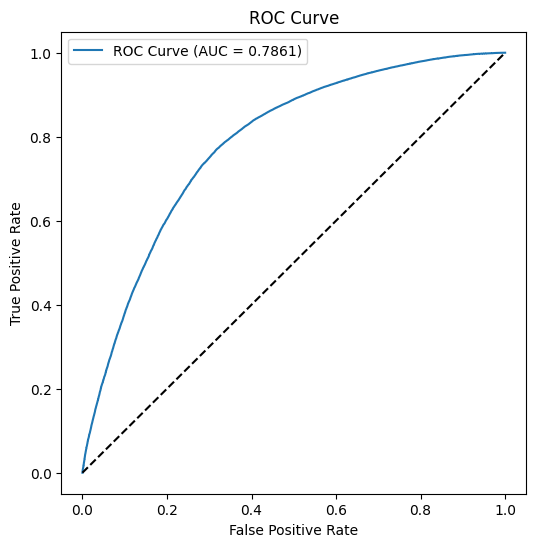

In [16]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(outputs.flatten())

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [ ]:
import torch

torch.save(model.state_dict(), 'D:/Photon_Electron_Detection/Model/model.pth')

model.load_state_dict(torch.load('D:/Photon_Electron_Detection/Model/model.pth'))


C:\Users\ROHAN\AppData\Local\Temp\ipykernel_29300\1021730417.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:/Photon_Electron_Detecti

<All keys matched successfully>

In [ ]:
import torch
import h5py

with h5py.File('D:/Photon_Electron_Detection/Model/model.h5', 'w') as f:
    for key, value in model.state_dict().items():
        f.create_dataset(key, data=value.cpu().numpy())


In [ ]:
import h5py

file_path = 'D:/Photon_Electron_Detection/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
hdf5_file = h5py.File(file_path, 'r')

print("Keys in HDF5 file:", list(hdf5_file.keys()))


Keys in HDF5 file: ['X', 'y']


In [ ]:
import torch

model = ResNet15() 
model.load_state_dict(torch.load('D:/Photon_Electron_Detection/Model/model.pth'))
model.eval()


C:\Users\ROHAN\AppData\Local\Temp\ipykernel_29300\1518838128.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:/Photon_Electron_Detecti

ResNet15(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (resblock2): ResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d

In [ ]:
import torch

model = ResNet15()  
model.load_state_dict(torch.load('D:/Photon_Electron_Detection/Model/model.pth'))
model.eval()  

C:\Users\ROHAN\AppData\Local\Temp\ipykernel_29300\3492125209.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('D:/Photon_Electron_Detecti

ResNet15(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (resblock1): ResNetBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (resblock2): ResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Conv2d

In [29]:
import h5py

file_path = 'D:/Photon_Electron_Detection/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
with h5py.File(file_path, 'r') as hdf:
    X = hdf['X'][:]
    y = hdf['y'][:]

print(X.shape, y.shape)


(249000, 32, 32, 2) (249000,)
